# Table of Contents
* [Build annotation skeleton code](#Build-annotation-skeleton-code)
* [Run](#Run)


In [1185]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm

from IPython.display import Image
import random

# Build annotation skeleton code

## code

In [6]:
main_characters = [
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
]

In [80]:
single_clip_template = {
    "globalID": "",
    "keyFrames": [],
    "setting": "",
    "characters": []
    }

character_template = {
#     "locationPreposition": "",
    "characterID": "",
    "characterName": "",
#     "pose": "",
    'rects': [[], [], []],
    "nearbyObject": "",
    "interactsWith": {
        "positionID":  "",
        "name": ""
    }
}


keyframe_postfixes = ['_' + str(x) + '.png' for x in [40]]


def make_global_id(video_name):
    return os.path.splitext(video_name)[0]


def make_clip_base_anno(video_fn):
    this_clip_anno = copy.deepcopy(single_clip_template)
    this_clip_anno['globalID'] = make_global_id(video_fn)
    this_clip_anno['keyFrames'] = [this_clip_anno['globalID'] + x for x in keyframe_postfixes]
    return this_clip_anno


def make_ds_skeleton(video_files):
    ds_skeleton = []
    for vf in video_files:
        ds_skeleton.append(make_clip_base_anno(vf))
    return ds_skeleton

##  Run 

In [8]:
keyframe_dir = '/Users/schwenk/wrk/animation_gan/build_dataset/Flintstone_Shots_Selected_Frames/'
selection_metadata_dir = 'Flintstone_Shots_GIF_Selection'
s3_dir = '/Users/schwenk/wrk/animation_gan/ai2-vision-animation-gan/annotation_data/still_frames/'

In [9]:
with open(os.path.join(selection_metadata_dir, 'beta_gif_names.json')) as f:
    beta_videos = json.load(f)
        
with open(os.path.join(selection_metadata_dir, 'production_gif_names.json')) as f:
    production_videos = json.load(f)

In [10]:
len(production_videos)

52313

In [11]:
len(beta_videos)

5084

In [12]:
2000 * 3 * 3 * 0.05

900.0

In [13]:
len(production_videos)

52313

In [14]:
with open('../turk_annotation_task/stage_1/complete_clips.txt', 'r') as f:
    clips_completed_raw = f.read()

clips_completed = set(clips_completed_raw.split())

In [15]:
beta_videos_remaining = [vid for vid in beta_videos if vid[:-4] not in clips_completed]

In [16]:
len(beta_videos_remaining)

1632

In [17]:
beta_200_random_sample = random.sample(beta_videos_remaining, 1632)

In [18]:
ds_production = make_ds_skeleton(production_videos)

In [70]:
# for clip in ds_last_beta:
#     for still in clip['keyFrames']:
#         try:
#             os.symlink(keyframe_dir + still, s3_dir + still)
#         except FileExistsError:
#             pass

In [37]:
with open('ds_production.json', 'w') as f:
    json.dump(ds_production, f)

In [490]:
# [vid for vid in ds_production if vid['globalID'] == 's_02_e_29_shot_014705_014779']

# Update ds with annotation results

In [19]:
from amt_utils.mturk import unpickle_this, pickle_this

In [20]:
processed_stage_1_a = unpickle_this('./stage_1/processed_stage1_boxes.pkl')
processed_stage_1_b = unpickle_this('./stage_1/stage_1b_prod_con_boxes_8_28.pkl')

processed_stage_1_a_all_boxes = unpickle_this('./stage_1/processed_stage1_boxes_all_boxes.pkl')
processed_stage_1_b_all_boxes = unpickle_this('./stage_1/stage_1b_prod_all_boxes_8_29.pkl')

In [1081]:
len(processed_stage_1_a)

19999

In [1083]:
len(processed_stage_1_b)

18696

In [534]:
ds_production = make_ds_skeleton(production_videos)

In [535]:
vid_bins = unpickle_this('vid_bin_assignments.pkl')

1,2,9,10

In [536]:
pass_bins = set(['bin_01_vids', 'bin_02_vids', 'bin_09_vids', 'bin_10_vids'])

In [1037]:
def untranslate_box(box):
    frame_width = 640
    box_copy = copy.deepcopy(box)
    box_copy[0], box_copy[2] = box_copy[0] - frame_width, box_copy[2] - frame_width
    return box_copy
    
def update_video_stage_1(vid, stage_1a, stage_1b):
    aid = vid['globalID']
    char_boxes_a = sorted(stage_1a[aid], key=lambda x: x['area'], reverse=True)
    char_boxes_b = sorted(stage_1b[aid], key=lambda x: x['label'])

    for idx, char in enumerate(char_boxes_a):
        char_temp = copy.deepcopy(character_template)
        char_temp['characterName'] = char['chosen_labels']   
        char_temp['characterID'] = aid + '_char_' + str(idx)
        char_temp['rects'][1] = char['box'].tolist()
        stage_b_boxes = sorted(char_boxes_b[idx * 2: (idx + 1) * 2], key=lambda x: x['box'][0])
        char_temp['rects'][0] = stage_b_boxes[0]['box'].tolist()
        char_temp['rects'][2] = untranslate_box(stage_b_boxes[1]['box']).tolist()
        char_temp['imageID'] = stage_b_boxes[0]['label']
        vid['characters'].append(char_temp)
        

def update_video_stage_3a(vid, setting_annotations):
    if vid['globalID'] in setting_annotations:
        vid['setting'] = setting_annotations[vid['globalID']]

## update stage 1

In [1080]:
ds_production = make_ds_skeleton(production_videos)
ds_complete_stage1_v1 = [vid for vid in ds_production if vid['globalID'] in processed_stage_1_a and vid['globalID'] in processed_stage_1_b]

In [1084]:
stg1a = set(processed_stage_1_a.keys())
stg1b = set(processed_stage_1_b.keys())

In [1085]:
len(stg1a.difference(stg1b))

2741

In [1087]:
list(stg1b.difference(stg1a))[0]

's_05_e_17_shot_017314_017388'

In [1089]:
's_05_e_17_shot_017314_017388.gif' in production_videos[0]

False

In [1086]:
len(stg1b.difference(stg1a))

1438

In [1042]:
single_clip = [vid for vid in ds_production if vid['globalID'] == 's_01_e_02_shot_014615_014689'][0]

In [1043]:
pass_vids = [vid for bin_n, vid in vid_bins.items() if bin_n in pass_bins]
pass_vid_ids = set([item for sublist in pass_vids for item in sublist])

In [1044]:
ds_complete_stage1_v1 = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] in pass_vid_ids]

In [1045]:
len(ds_complete_stage1_v1)

12819

In [1046]:
shot_change = []

for video in tqdm(ds_complete_stage1_v1):
    try:
        update_video_stage_1(video, processed_stage_1_a, processed_stage_1_b)
    except IndexError:
        shot_change.append(video['globalID'])

100%|██████████| 12819/12819 [00:00<00:00, 17935.92it/s]


In [1047]:
len(shot_change)

1651

In [1183]:
from IPython.display import Image

In [1194]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/scene_gifs/'
single_clip = shot_change[6]
image_url = s3_base_path + single_clip + '.gif'

# Image(url=image_url)

In [1048]:
ds_complete_stage1_v1_all_clean = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] not in shot_change]

In [1049]:
len(ds_complete_stage1_v1_all_clean) / 12819

0.8712068024026836

In [1050]:
# weird_vid = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] == 's_06_e_24_shot_005808_005882']

In [1051]:
single_char_clips = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) == 1]

In [1052]:
multi_char_clips = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) > 1 and len(clip['characters']) < 4]

In [1053]:
all_reasonably_sized = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) > 0 and len(clip['characters']) < 4]

In [1079]:
len(all_reasonably_sized)

10893

In [67]:
# multi_char_sample = random.sample(multi_char_clips, 100)

In [65]:
len(multi_char_sample)

100

In [76]:
# pickle_this(multi_char_clips, 'stage_1_multi_char_sample.pkl')

In [1016]:
# pickle_this(all_reasonably_sized, 'stage_1_less_than_4chars.pkl')

In [61]:
# pickle_this(single_char_clips, 'stage_1_single_char_updated.pkl')

In [939]:
# single_clip = three_char_clips[1]
# single_clip 

## update stage3

In [1055]:
stage_3a_settings = unpickle_this('stage_3/stage3_prod1_2_settings.pkl')

In [1056]:
for video in all_reasonably_sized:
    update_video_stage_3a(video, stage_3a_settings)

In [1057]:
len(all_reasonably_sized)

10893

In [1058]:
for video in all_reasonably_sized:
    if not video['setting']:
        print(video)
    if not video['characters']:
        print(video)

# clean and spellcheck

In [1059]:
import enchant
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

from fuzzywuzzy import fuzz
import difflib
import diff_match_patch

dmp = diff_match_patch.diff_match_patch()

edict = enchant.Dict("en_US")
anglo_edict = enchant.Dict("en_UK")
cached_sw = stopwords.words("english") + list(string.punctuation)

#         edict.add(word)

In [1149]:
other_chars_names = ['gazoo', 'lodabricks', 'slaghoople', 'poobaah']

In [1150]:
other_words = ['bandana', 'tv', 'bandana', 'bowtie', 'sabretooth', 'creepella', 'polkadot', 
               'turban', 'monical', 'unibrow', 'accordion', 'boutineer', 'handkerchief', 'xray', 
               'onesie', 'midcentury', 'cafe', 'squatty', 'earings']

In [1151]:
words_to_remove = ['whine', 'turbine', 'accordant', 'according', 'turbid', 'voile', 'acous', 'google', 'leper', 'deres', 'powerless', 'powerfulness', 'fervent', 'weaning', 'grail']
_ = [edict.remove_from_session(word) for word in words_to_remove]

In [1152]:
_ = [[edict.add(char_word.lower()) for char_word in char.split()] for char in main_characters + other_chars_names + other_words]

In [1153]:
manual_corrections = {  'lieing': 'lying',
                        'infront': 'in font',
                        'ladie': 'lady',
                        'servent': 'servant',
                        'wiht': 'with',
                        'preformer': 'performer',
                        'hinging': 'hanging',
                        'bule': 'blue',
                        'yount': 'young',
                      'od': 'old',
                      'dres': 'dress',
                      'handshacking': 'hand shaking',
                      'cru': 'crew',
                      'hankerchief': 'handkerchief',
                      'cowbow': 'cowboy',
                      'helmit': 'helmet',
                      'wearning': 'wearing',
                      'broen': 'wearing'
                     }

In [1154]:
def check_mispelled(word):
    return word and word.isalpha() and not (edict.check(word) or anglo_edict.check(word) or edict.check(word[0].upper() + word[1:]))

def check_word_rules(word):
    split_len = 2 < min([len(w) for w in word.split()])
    not_proper = word[0].islower()
    return not_proper and split_len

def correct_spelling_error(misspelled_word):
    if misspelled_word in manual_corrections:
        return manual_corrections[misspelled_word]
    suggested_spellings = edict.suggest(misspelled_word)
    match_ratios = [fuzz.token_sort_ratio(misspelled_word, word) for word in suggested_spellings]
    words_sorted_by_ratio = sorted(zip(suggested_spellings, match_ratios), key=lambda x: x[1], reverse=True)
    words_sorted_by_ratio = [wordscore for wordscore in words_sorted_by_ratio if check_word_rules(wordscore[0])]
    check_compounds = [word[0] for word in words_sorted_by_ratio if word[0].replace(' ', '') == misspelled_word]
    if check_compounds:
        return check_compounds[0]
    if words_sorted_by_ratio[0][1] > 80:
        return words_sorted_by_ratio[0][0]

    for word, score in words_sorted_by_ratio:
        if score >= 75 and word[0] == misspelled_word[0]:
            return word
        elif score >= 75:                    
            return word
    return None

def apply_spelling_fix(orig_text):
    orig_text_tokens = wordpunct_tokenize(orig_text)
    processed_tokens = []
    for token in orig_text_tokens:
        norm_token = token.lower()
        if len(norm_token) < 4:
            processed_tokens.append(token)
            continue
        if check_mispelled(norm_token):
            suggested_replacements = edict.suggest(token)
            replacement_text = correct_spelling_error(norm_token, suggested_replacements)
            if replacement_text:
                if norm_token[0].isupper():
                    replacement_text = upper(replacement_text[0]) + replaced_text[1:]
                processed_tokens.append(replacement_text)
            else:
                processed_tokens.append(token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

def diff_corrected_text(orig_text, corrected_text):
    diff = dmp.diff_main(orig_text, corrected_text)
    return HTML(dmp.diff_prettyHtml(diff))

def specify_lesson_q_path(lesson):
    pass

def apply_spelling_and_grammar_to_ds(ck12_ds):
    return

In [1136]:
def remove_empty_fields(video):
    video.pop()

In [1155]:
dataset_v0p1 = copy.deepcopy(all_reasonably_sized)

In [1156]:
words_changed = []
for video in dataset_v0p1:
    for char in video['characters']:
        char_name_words = wordpunct_tokenize(char['characterName'])
        misspellings = [check_mispelled(word) for word in char_name_words]
        if sum(misspellings):
            for idx, is_mispelled in enumerate(misspellings):
                if is_mispelled:
                    suggested_replacement = correct_spelling_error(char_name_words[idx])
                    if suggested_replacement:
                        words_changed.append([char_name_words[idx], suggested_replacement])
                        char_name_words[idx] = suggested_replacement
#                     print(char_name_words, suggested_replacement)
#             print(char['characterName'], ' '.join(char_name_words).replace(' , ', ', ').replace(' . ', '.'))
            char['characterName'] = ' '.join(char_name_words).replace(' , ', ', ').replace(' . ', '.')
#         print(list(zip(char_name_words, misspellings)))

In [1157]:
len(words_changed)

155

In [1158]:
for video in dataset_v0p1:
    setting = video['setting']
    setting_words = setting.split()
    misspellings = [check_mispelled(word) for word  in setting_words]
    if sum(misspellings):
        for idx, is_mispelled in enumerate(misspellings):
            if is_mispelled:
                suggested_replacement = correct_spelling_error(setting_words[idx])
                if suggested_replacement:
                    words_changed.append([setting_words[idx], suggested_replacement])
                    setting_words[idx] = suggested_replacement
        video['setting'] = ' '.join(setting_words)

In [1161]:
pickle_this(dataset_v0p1, 'dataset_v0p1.pkl')

with open('dataset_v0p1.json', 'w') as f:
    json.dump(dataset_v0p1, f, indent=4, sort_keys=True)

In [1163]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

In [1143]:
len(dataset_v0p1)

10893

In [1164]:
len(dataset_v0p1)

10893

In [1162]:
dataset_v0p1[100]

{'characters': [{'characterID': 's_05_e_17_shot_006072_006146_char_0',
   'characterName': 'bamm bamm',
   'imageID': 's_05_e_17_shot_006072_006146_char_0_taskb.png',
   'interactsWith': {'name': '', 'positionID': ''},
   'nearbyObject': '',
   'rects': [[236, 49, 478, 405], [190, 62, 480, 405], [187, 72, 478, 406]]}],
 'globalID': 's_05_e_17_shot_006072_006146',
 'keyFrames': ['s_05_e_17_shot_006072_006146_40.png'],
 'setting': 'dining room'}

In [1145]:
for video in dataset_v0p1:
    if not video['setting']:
        print(video['globalID'])
    if not video['characters']:
        print(video['globalID'])

# video status tagging

In [1166]:
videos_to_pass = unpickle_this('../turk_annotation_task/stage_1/vids_to_pass_9_8.pkl')

In [1167]:
len(videos_to_pass)

13679

In [1171]:
pass_vids = [vid for vid in dataset_v0p1 if vid['globalID'] in videos_to_pass]
for vid in dataset_v0p1:
    if vid['globalID'] in videos_to_pass:
        vid['status'] = 'go'

In [1172]:
pass_vids[0]

{'characters': [{'characterID': 's_01_e_24_shot_033229_033303_char_0',
   'characterName': 'fred',
   'imageID': 's_01_e_24_shot_033229_033303_char_0_taskb.png',
   'interactsWith': {'name': '', 'positionID': ''},
   'nearbyObject': '',
   'rects': [[130, 116, 232, 380],
    [128, 113, 239, 380],
    [127, 108, 237, 383]]},
  {'characterID': 's_01_e_24_shot_033229_033303_char_1',
   'characterName': 'barney',
   'imageID': 's_01_e_24_shot_033229_033303_char_1_taskb.png',
   'interactsWith': {'name': '', 'positionID': ''},
   'nearbyObject': '',
   'rects': [[238, 163, 345, 377],
    [244, 164, 345, 376],
    [241, 168, 344, 374]]}],
 'globalID': 's_01_e_24_shot_033229_033303',
 'keyFrames': ['s_01_e_24_shot_033229_033303_40.png'],
 'setting': 'doorway',
 'status': 'go'}

# HTML Review

## generate

In [613]:
import cv2

In [809]:
from amt_utils.bboxes import draw_clusters

In [859]:
keyframe_postfixes = ['_' + str(x) + '.png' for x in [10, 40, 70]]
image_dir_base = '/Users/schwenk/wrk/animation_gan/ai2-vision-animation-gan/annotation_data/still_frames/'
review_frame_dir = './review_stage_1_results/review_frames/'

In [860]:
def random_color():
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 1)

def draw_character_boxes(frame_images, char_anno):
    color = random_color()
    for frame_idx, char_box in enumerate(char_anno['rects']):
        char_box = char_box.reshape(2, 2)
        img = frame_images[frame_idx]
        max_height, max_width, channels = img.shape
        limit_rect(char_box, max_width, max_height)
        cv2.rectangle(img, tuple(char_box[0]), tuple(char_box[1]), color=color, thickness=2)
#         cv2.putText(img, char_anno['characterName'].upper(), tuple(char_box[0] + np.array([0, 50])), cv2.FONT_HERSHEY_SIMPLEX , 2, color, 2)
        
def limit_rect(rect, max_x, max_y, border_pad=2):
    if rect[0][0] < 0:
        rect[0][0] = border_pad
    if rect[0][1] < 0:
        rect[0][1] = border_pad
    if rect[1][0] > max_x:
        rect[1][0] = max_x - border_pad
    if rect[1][1] > max_y:
        rect[1][1] = max_y - border_pad

def draw_annotation_review_image(image_annotation):
    image_fnames = [image_annotation['globalID'] + pfix for pfix in keyframe_postfixes]
    image_paths = [os.path.join(image_dir_base, img_fn) for  img_fn in image_fnames]
    frame_images = [cv2.imread(img_path) for img_path in image_paths]
    frame_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in frame_images]
    _ = [draw_character_boxes(frame_images, char) for char in image_annotation['characters']]
    seq_img = Image.fromarray(np.hstack([img for img in frame_images if img.any()]))
    rev_img_path = os.path.join(review_frame_dir, image_annotation['globalID'] ) + '_rev.png'
    seq_img.save(rev_img_path)

In [961]:
noncon_vids = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] in shot_change]

In [962]:
review_seq = {}
for animation_annos in tqdm(random.sample(noncon_vids, 100)):
    drawn_image = draw_annotation_review_image(animation_annos)
    review_seq[animation_annos['globalID']] = {'chosen_labels': [char['characterName'] for char in sorted(animation_annos['characters'], key=lambda x: x['rects'][0][0])]}
    
rev_page = generate_master_review_page(review_seq, 'stage_1_bin_1_non_con.html')

100%|██████████| 100/100 [00:57<00:00,  2.02it/s]


In [875]:
processed_stage_1_b_all_boxes['s_06_e_07_shot_020636_020710']

{'all_boxes': [{'area': 35112,
   'box': array([ 68,  97, 201, 361]),
   'duplicate_of': 0,
   'idx': 4,
   'label': 's_06_e_07_shot_020636_020710_char_2_taskb.png'},
  {'area': 34671,
   'box': array([717,  90, 844, 363]),
   'duplicate_of': 1,
   'idx': 5,
   'label': 's_06_e_07_shot_020636_020710_char_2_taskb.png'},
  {'area': 32131,
   'box': array([724, 106, 851, 359]),
   'duplicate_of': 1,
   'idx': 3,
   'label': 's_06_e_07_shot_020636_020710_char_2_taskb.png'},
  {'area': 31823,
   'box': array([721, 102, 842, 365]),
   'idx': 1,
   'label': 's_06_e_07_shot_020636_020710_char_2_taskb.png',
   'votes': 3},
  {'area': 31097,
   'box': array([ 87, 104, 208, 361]),
   'duplicate_of': 0,
   'idx': 2,
   'label': 's_06_e_07_shot_020636_020710_char_2_taskb.png'},
  {'area': 30128,
   'box': array([ 85,  98, 197, 367]),
   'idx': 0,
   'label': 's_06_e_07_shot_020636_020710_char_2_taskb.png',
   'votes': 3}],
 'con_boxes': [{'area': 44023,
   'box': array([ 996,   61, 1129,  392]),
  

## page_code

In [853]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

import jinja2
from jinja2 import Environment, FileSystemLoader
j2env = jinja2.Environment()

def make_uri(clip_id, s3_base='review_frames/', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base=s3_base_path):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_master_review_page(rev_seq, out_page='master_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in review_seq.items()]
    sorted_clip_ids = list(rev_seq.keys())
    chosen_labels = [img[1]['chosen_labels'] for img in review_seq.items()]

    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, range(1, len(rev_seq) + 1)[::-1], chosen_labels)
    env = Environment()
    template =  j2env.from_string(master_review_html)
    html_dir = './review_stage_1_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html


def generate_review_page(review_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

In [862]:
master_review_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip {{clip[2]}}: {{clip[0]}}</h2>
        <p>{{clip[1]}}</p>
        <p>{{clip[3]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_single_frame_page_html = """
<!DOCTYPE html>
<html>JM
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <p>{{clip[1]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

# review

In [873]:
single_clip

{'characters': [{'characterID': 's_06_e_07_shot_020636_020710_char_0',
   'characterName': 'fred',
   'imageID': 's_06_e_07_shot_020636_020710_char_0_taskb.png',
   'interactsWith': {'name': '', 'positionID': ''},
   'locationPreposition': '',
   'nearbyObject': '',
   'pose': '',
   'rects': [array([996,  61, 638, 392]),
    array([365,  37, 484, 339]),
    array([496, 106, 595, 395])]},
  {'characterID': 's_06_e_07_shot_020636_020710_char_1',
   'characterName': 'betty',
   'imageID': 's_06_e_07_shot_020636_020710_char_1_taskb.png',
   'interactsWith': {'name': '', 'positionID': ''},
   'locationPreposition': '',
   'nearbyObject': '',
   'pose': '',
   'rects': [array([197, 106, 338, 318]),
    array([199, 106, 338, 317]),
    array([  2, 133, -64, 361])]},
  {'characterID': 's_06_e_07_shot_020636_020710_char_2',
   'characterName': 'wilma',
   'imageID': 's_06_e_07_shot_020636_020710_char_2_taskb.png',
   'interactsWith': {'name': '', 'positionID': ''},
   'locationPreposition': ''

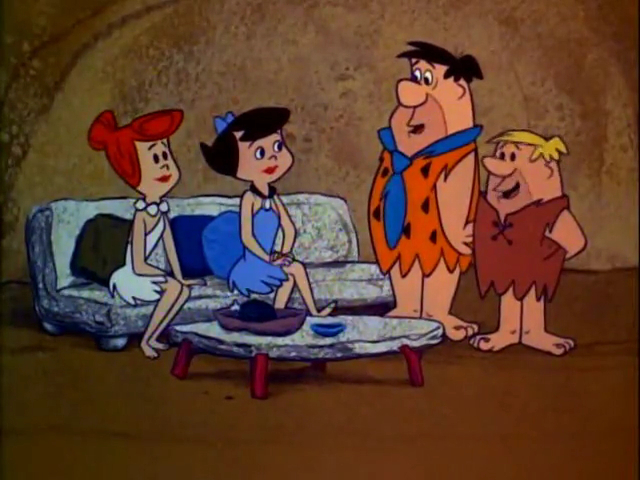

In [867]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'
s3_subtask_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/subtask_frames/'

single_clip = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] == 's_06_e_07_shot_020636_020710'][0]
# single_clip = ds_complete_stage1_v1[0]
image_url = s3_base_path + single_clip['globalID'] + '_40.png'
Image.open(requests.get(image_url, stream=True).raw)

barney


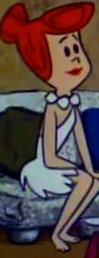

In [872]:
this_char = single_clip['characters'][3]
print(this_char['characterName'])

char_url = s3_subtask_path + this_char['imageID']
Image.open(requests.get(char_url, stream=True).raw)

# hide

In [403]:
# pickle_this(single_char_clips, 'stage1_single_char_ds_v1.pkl')

In [65]:
# with open('skeleton_dataset.json', 'w') as f:
#     json.dump(ds_skeleton, f)

# with open('skeleton_dataset_gold.json', 'w') as f:
#     json.dump(ds_skeleton_gold, f)

# with open('ds_interface_2_skeleton.json', 'w') as f:
#     json.dump(ds_interface_2_skeleton, f)



In [ ]:
## all boxes

ds_complete_stage1_v1 = [vid for vid in ds_production if vid['globalID'] in processed_stage_1_a and vid['globalID'] in pass_vid_ids]

len(ds_complete_stage1_v1)

shot_change = []
for video in tqdm(ds_complete_stage1_v1):
    try:
        update_video_stage_1(video, processed_stage_1_a, processed_stage_1_b)
    except IndexError:
        shot_change.append(video['globalID'])